# Personal Information
Name: **Klara Willberg**

StudentID: **12682586**

Email: [**klara.willberg@student.uva.nl**](youremail@student.uva.nl)


# Data Context

The "data" that is being explored in this thesis project is the BioBERT language model. The BioBERT language model is a fine-tuned verision of BERT that was specifically trained on biomedical corpora such as PMc (PubMed Central) full-text documents and PubMed abstracts to enhance ints understanding of biomedical text. This thesis project intends to evaluate the word embeddings of genes within the BioBERT model, and assess to what extent relatedness and similarities between genes can be inferred from biomedical text.

# Data Description

Below you can find the code for the EDA of BioBERT. This EDA includes exploring how words are tokenized by the BioBERT tokenizer, the distribution of token lengths and the distribution of subword lengths. Moreover, I explore the proportion of subwords compared to the whole BioBERT vocabulary.

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
from transformers import BertTokenizer, BertModel

### Data Loading

In [ ]:
# !pip install pytorch-pretrained-bert

In [ ]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy.spatial.distance import cosine
from transformers import BertTokenizer, BertModel


#DIFFERENT MODELS OF BIOBERT TO TRY:
#dmis-lab/biobert-base-cased-v1.2: Trained in the same way as BioBERT-Base v1.1 but includes LM head, which can be useful for probing
#dmis-lab/biobert-base-cased-v1.1: BioBERT-Base v1.1 (+ PubMed 1M)
#dmis-lab/biobert-large-cased-v1.1: BioBERT-Large v1.1 (+ PubMed 1M)
#dmis-lab/biobert-base-cased-v1.2: BioBERT-Base v1.2 (+ PubMed 1M + LM head)

# # Load pre-trained BioBERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# model = BertModel.from_pretrained("dmis-lab/biobert-v1.1")

# tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")
# model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# inspect BioBERT vocabulary

In [ ]:
with open("vocabulary.txt", 'w') as f:

    # For each token...
    for token in tokenizer.vocab.keys():

        # Write it out and escape any unicode characters.
        f.write(token + '\n')

In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
one_chars = []
one_chars_hashes = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():

    # Record any single-character tokens.
    if len(token) == 1:
        one_chars.append(token)

    # Record single-character tokens preceded by the two hashes.
    elif len(token) == 3 and token[0:2] == '##':
        one_chars_hashes.append(token)

In [ ]:
print('Number of single character tokens with hashes:', len(one_chars_hashes), '\n')

# Print all of the single characters, 40 per row.

# Strip the hash marks, since they just clutter the display.
tokens = [token.replace('##', '') for token in one_chars_hashes]

# For every batch of 40 tokens...
for i in range(0, len(tokens), 40):

    # Limit the end index so we don't go past the end of the list.
    end = min(i + 40, len(tokens) + 1)

    # Print out the tokens, separated by a space.
    print(' '.join(tokens[i:end]))

Number of single character tokens with hashes: 997 

s a e i n o d r y t l m u h k c g p 2 z 1 b 3 f 4 6 7 x v 8 5 9 0 w j q ° ₂ а и
² ₃ ı ₁ ⁺ ½ о ه ي α е د ن ν ø р ₄ ₀ ر я ³ ι ł н ᵢ ₙ ß ة ς م − т ː ل ь к ♭ η ی в
ا × ¹ ы ה ɛ л ! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ ¡
¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ® ± ´ µ ¶ · º » ¼ ¾ ¿ æ ð ÷ þ đ ħ ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ˡ ˢ ˣ ˤ β γ δ ε ζ
θ κ λ μ ξ ο π ρ σ τ υ φ χ ψ ω б г д ж з м п с у ф х ц ч ш щ ъ э ю ђ є і ј љ њ ћ
ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ ք ־ א ב ג ד ו ז ח ט י ך כ ל ם מ ן נ ס
ע ף פ ץ צ ק ר ש ת ، ء ب ت ث ج ح خ ذ ز س ش ص ض ط ظ ع غ ـ ف ق ك و ى ٹ پ چ ک گ ں ھ
ہ ے अ आ उ ए क ख ग च ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ
ই উ এ ও ক খ গ চ ছ জ ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப
ம ய ர ல ள வ ா ி ு ே ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད
ན པ བ མ འ ར ལ ས မ ა ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ

In [ ]:
print('Are the two sets identical?', set(one_chars) == set(tokens))

Are the two sets identical? True


In [ ]:
# tokenizer.vocab.keys()

In [ ]:
# # Load pre-trained BioBERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# model = BertModel.from_pretrained("dmis-lab/biobert-v1.1")

tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")
model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# How are words tokenized by BioBERT?

In [ ]:
# Define the input text
text = "penicillin"

# Tokenize the input text
tokens = tokenizer.encode(text, add_special_tokens=True)

print(tokens)

#Convert the tokens back into words

token_words = tokenizer.convert_ids_to_tokens(tokens)
print(token_words)

[101, 7279, 28775, 21202, 102]
['[CLS]', 'pen', '##ici', '##llin', '[SEP]']


In [ ]:
def get_nearest_neighbors(embedding, embeddings_matrix, k=10):
    """
    Finds the k-nearest neighbors to a given embedding.

    Args:
    embedding: numpy array of shape (embedding_dim,), the embedding for which to find the nearest neighbors.
    embeddings_matrix: numpy array of shape (vocabulary_size, embedding_dim), the matrix of embeddings for the entire vocabulary.
    k: int, the number of nearest neighbors to find.

    Returns:
    indices: list of length k, the indices of the k-nearest neighbors in the embeddings_matrix.
    distances: list of length k, the distances from the nearest neighbors to the given embedding.
    """
    distances = np.linalg.norm(embeddings_matrix - embedding, axis=1)
    indices = np.argsort(distances)[:k]
    return indices, distances[indices]


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BioBERT model and tokenizer
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Get embeddings for each token in the vocabulary
vocab_embeddings = []
for token in tokenizer.get_vocab().keys():
    input_ids = torch.tensor(tokenizer.encode(token)).unsqueeze(0)
    embeddings = model(input_ids)[0].squeeze(0).detach().numpy()
    vocab_embeddings.append(embeddings)
vocab_embeddings = np.array(vocab_embeddings)


<ipython-input-13-eda0076a314f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vocab_embeddings = np.array(vocab_embeddings)


In [ ]:
# # Load pre-trained BioBERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# model = BertModel.from_pretrained("dmis-lab/biobert-v1.1")

# tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")
# model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Distribution of token length in the bioBERT vocabulary

Maximum token length: 18


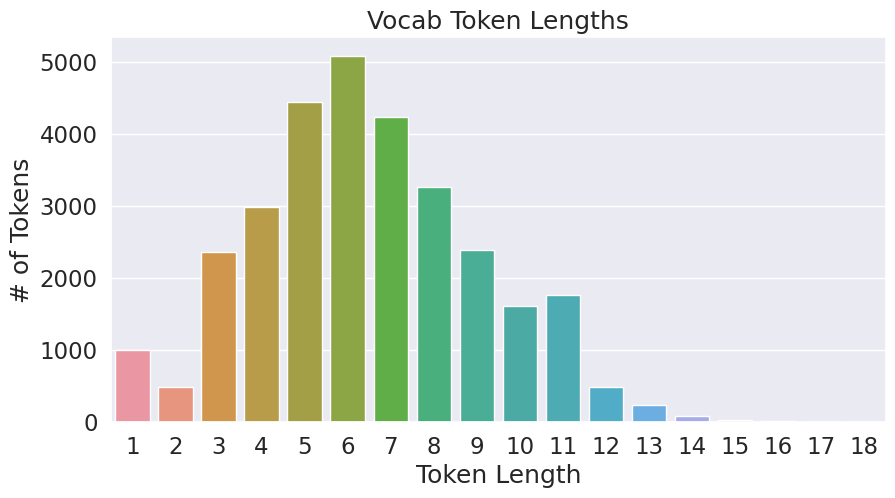

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Measure the length of every token in the vocab.
token_lengths = [len(token) for token in tokenizer.vocab.keys()]

# Count the frequency of each token length.
token_lengths_counts = pd.Series(token_lengths).value_counts().sort_index()

# Plot the number of tokens of each length.
sns.barplot(x=token_lengths_counts.index, y=token_lengths_counts)
plt.title('Vocab Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('# of Tokens')

print('Maximum token length:', max(token_lengths))


# Number of subwords (WordPiece tokenization)

In [ ]:
num_subwords = 0

subword_lengths = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():

    # If it's a subword...
    if len(token) >= 2 and token[0:2] == '##':

        # Tally all subwords
        num_subwords += 1

        # Measure the sub word length (without the hashes)
        length = len(token) - 2

        # Record the lengths.
        subword_lengths.append(length)


In [ ]:
vocab_size = len(tokenizer.vocab.keys())

print('Number of subwords: {:,} of {:,}'.format(num_subwords, vocab_size))

# Calculate the percentage of words that are '##' subwords.
prcnt = float(num_subwords) / vocab_size * 100.0

print('%.1f%%' % prcnt)

Number of subwords: 5,828 of 30,522
19.1%


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# sns.set(style='darkgrid')
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (10,5)

# # Measure the length of every subword in the vocab.
# subword_lengths = [len(subword.strip('##')) for subword in tokenizer.vocab.keys() if subword.startswith('##')]

# # Plot the number of ## subwords of each length.
# sns.countplot(subword_lengths)
# plt.title('Subword Token Lengths (w/o "##")')
# plt.xlabel('Subword Length')
# plt.ylabel('# of ## Subwords')

# print('Maximum subword length:', max(subword_lengths))


Text(0, 0.5, '# of Subwords')

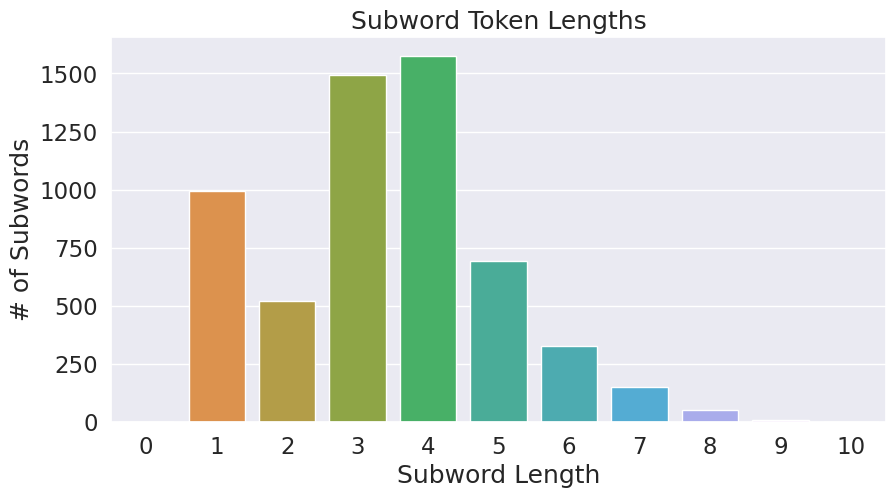

In [ ]:
# Measure the length of every subword in the vocab.
subword_lengths = [len(subword.strip('##')) for subword in tokenizer.vocab.keys() if subword.startswith('##')]

# Count the frequency of each subword length.
subword_lengths_counts = pd.Series(subword_lengths).value_counts().sort_index()

# Plot the number of ## subwords of each length.
sns.barplot(x=subword_lengths_counts.index, y=subword_lengths_counts)
plt.title('Subword Token Lengths')
plt.xlabel('Subword Length')
plt.ylabel('# of Subwords')


# Evaluating cosine similarity between some words

In [ ]:
from scipy.spatial.distance import cosine



# Input words
word1 = "gene"
word2 = "protein"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze()

# Get embeddings for word2
inputs2 = tokenizer(word2, return_tensors='pt')
outputs2 = model(**inputs2)
embedding2 = outputs2.last_hidden_state.mean(dim=1).squeeze()

# Calculate cosine similarity
similarity = 1 - cosine(embedding1.detach().numpy(), embedding2.detach().numpy())

# Print similarity
print("Cosine similarity:", similarity)

Cosine similarity: 0.8723239898681641


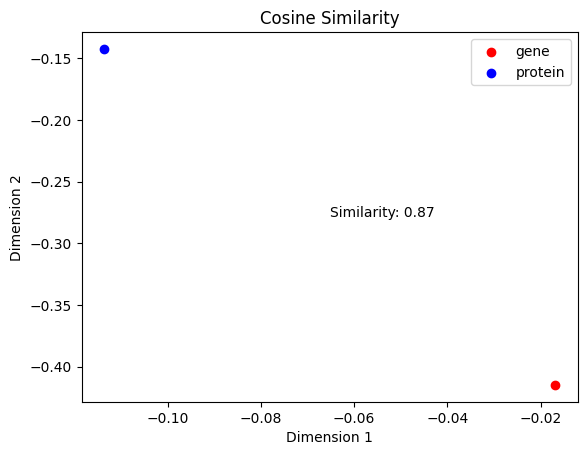

In [ ]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Input words
word1 = "gene"
word2 = "protein"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze()

# Get embeddings for word2
inputs2 = tokenizer(word2, return_tensors='pt')
outputs2 = model(**inputs2)
embedding2 = outputs2.last_hidden_state.mean(dim=1).squeeze()

# Calculate cosine similarity
similarity = 1 - cosine(embedding1.detach().numpy(), embedding2.detach().numpy())

# Create a scatter plot
plt.scatter(embedding1[0].item(), embedding1[1].item(), c='red', label=word1)
plt.scatter(embedding2[0].item(), embedding2[1].item(), c='blue', label=word2)

# Add labels and title to the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cosine Similarity')

# Add a text annotation to show the similarity value
plt.annotate(f'Similarity: {similarity:.2f}', xy=(0.5, 0.5), xycoords='axes fraction')

# Show the legend and plot
plt.legend()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Example word embeddings
word1_embedding = np.array([0.2, 0.5])
word2_embedding = np.array([-0.3, 0.8])

# Compute cosine distance
cosine_distance = 1 - cosine_similarity([word1_embedding], [word2_embedding])[0, 0]

# Create scatter plot
fig, ax = plt.subplots()

# Plot word embeddings as points
ax.scatter(word1_embedding[0], word1_embedding[1], color='red', label='Word A')
ax.scatter(word2_embedding[0], word2_embedding[1], color='blue', label='Word B')

# Draw a line or arrow between the points
ax.annotate('', xy=word1_embedding, xytext=word2_embedding,
            arrowprops=dict(arrowstyle='->', color='gray'))

# Add labels to the points
ax.text(word1_embedding[0], word1_embedding[1], 'Word A', ha='right')
ax.text(word2_embedding[0], word2_embedding[1], 'Word B', ha='left')

# Set plot limits
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)

# Add legend and title
ax.legend()
ax.set_title('Cosine Distance between Word Embeddings: {:.2f}'.format(cosine_distance))

# Show the plot
plt.show()


# Evaluating euclidean distance between some words

In [ ]:
from scipy.spatial.distance import euclidean

#embeddings from the above code
distance = euclidean(embedding1.detach().numpy(), embedding2.detach().numpy())
print("Euclidean distance:", distance)

Euclidean distance: 3.944382667541504


# **CLUSTERING**

In [ ]:
import torch


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


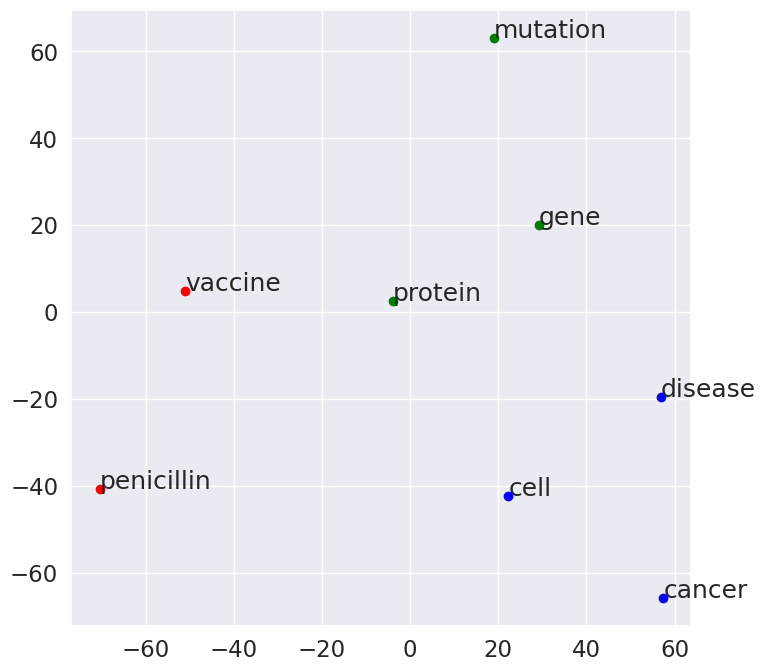

In [ ]:
 from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
model = AutoModel.from_pretrained('dmis-lab/biobert-v1.1')

# Define a list of words to cluster
words = ['gene', 'protein', 'mutation', 'cell', 'disease', 'cancer', 'vaccine', 'penicillin']

# Generate embeddings for the words using the BioBERT model
embeddings = []
for word in words:
    # Tokenize the word and convert it to a tensor
    input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
    # Get the embeddings for the tokenized input
    with torch.no_grad():
        output = model(input_ids)
    # Extract the final hidden state of the first token (the [CLS] token)
    embedding = output[0][:, 0, :].numpy()
    embeddings.append(embedding)

# Reshape the embeddings to remove the third dimension
embeddings = np.array(embeddings)
n_samples, n_dims, _ = embeddings.shape
embeddings = embeddings.reshape(n_samples, n_dims * _)

# Apply KMeans clustering to the embeddings
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embeddings)

# Get the labels for each word
labels = kmeans.labels_

tsne = TSNE(n_components=2, perplexity =5)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the embeddings in a scatter plot
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green']
for i in range(n_clusters):
    cluster_words = [words[j] for j in range(len(words)) if labels[j] == i]
    cluster_embeddings = embeddings_tsne[labels == i]
    x = cluster_embeddings[:, 0]
    y = cluster_embeddings[:, 1]
    plt.scatter(x, y, color=colors[i])
    for j, word in enumerate(cluster_words):
        plt.annotate(word, (x[j], y[j]))
plt.show()

# **GET NEAREST NEIGHBORS OF INPUT WORD**

In [ ]:
word1 = 'gene'

inputs = tokenizer(word1, return_tensors='pt')
outputs = model(**inputs)
embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# from sklearn.neighbors import NearestNeighbors

# # set up BioBERT tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
# model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# # get the full BioBERT vocabulary
# vocab = tokenizer.get_vocab()

# # extract the embedding for the input word from the BioBERT model
# # input_word = "gene"
# # input_word_tokens = tokenizer.encode_plus(input_word, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
# # with torch.no_grad():
# #     input_word_embedding = model(**input_word_tokens).last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# input_word ='gene'
# input_word_to = tokenizer(input_word, return_tensors='pt')
# input_word_tokens = model(**input_word_to)
# input_word_embedding = input_word_tokens.last_hidden_state.mean(dim=1).squeeze()

# # find the embeddings and words for all words in the vocabulary that have at least 4 characters
# embeddings = []
# words = []
# for word in vocab:
#     if len(word) >= 4:
#         word_idx = vocab[word]
#         embedding = model.embeddings.word_embeddings(torch.tensor(word_idx)).cpu().detach().numpy()
#         embeddings.append(embedding)
#         words.append(word)

# # use KNN to find the most similar words to the input word
# n_neighbors = 10
# nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
# nn.fit(embeddings)
# distances, indices = nn.kneighbors([input_word_embedding])

# # print the closest words to the input word
# print("Closest words to '%s':" % input_word)
# for i in range(n_neighbors):
#     print(words[indices[0][i]])


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors

# set up BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# get the full BioBERT vocabulary
vocab = tokenizer.get_vocab()

# extract the embedding for the input word from the BioBERT model
input_word = "gene"
input_word_tokens = tokenizer.encode_plus(input_word, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
with torch.no_grad():
    input_word_embedding = model(**input_word_tokens).last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# find the embeddings and words for all words in the vocabulary that have at least 4 characters
embeddings = []
words = []
for word in vocab:
    if len(word) >= 4:
        word_idx = vocab[word]
        with torch.no_grad():
            embedding = model.embeddings.word_embeddings(torch.tensor(word_idx)).cpu().detach().numpy()
        embeddings.append(embedding)
        words.append(word)

# use KNN to find the most similar words to the input word
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn.fit(embeddings)
distances, indices = nn.kneighbors([input_word_embedding])

# print the closest words to the input word
print("Closest words to '%s':" % input_word)
for i in range(n_neighbors):
    print(words[indices[0][i]])


Closest words to 'gene':
[CLS]
[MASK]
[SEP]
with
from
were
that
this
during
these


In [ ]:
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze()

# **Knowledge graph construction of a gene**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors

# set up BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# extract embeddings for the word "cancer" from the BioBERT vocabulary
word = "gene"
word_tokens = tokenizer.encode_plus(word, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
with torch.no_grad():
    word_embeddings = model(**word_tokens).last_hidden_state.mean(dim=1).squeeze().numpy()

# find the most similar embeddings to the word embedding using KNN
n_neighbors = 10  # number of nearest neighbors to find
metric = 'cosine'  # distance metric to use
nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
nn.fit(model.embeddings.word_embeddings.weight.data.cpu().numpy())
distances, indices = nn.kneighbors(word_embeddings.reshape(1, -1))

# print the closest words to the input word
closest_words = [tokenizer.decode([i]) for i in indices[0]]
print("Closest words to '%s': %s" % (word, closest_words))


Closest words to 'gene': ['[CLS]', '[MASK]', '.', '[SEP]', ',', 'the', 'of', '(', 'to', '-']


In [ ]:
from scipy.spatial.distance import cosine


# Input words
word1 = "gene"
word2 = "protein"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze()

# Get embeddings for word2
inputs2 = tokenizer(word2, return_tensors='pt')
outputs2 = model(**inputs2)
embedding2 = outputs2.last_hidden_state.mean(dim=1).squeeze()

# Calculate cosine similarity
similarity = 1 - cosine(embedding1.detach().numpy(), embedding2.detach().numpy())

# Print similarity
print("Cosine similarity:", similarity)

Cosine similarity: 0.9467215538024902


In [ ]:
# Input words
word1 = "gene"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze()

print(embedding1)

tensor([ 4.6580e-01, -6.6418e-02, -4.1979e-01, -4.5854e-01, -2.5833e-01,
        -9.8215e-02,  4.2110e-01,  1.0692e-01, -1.2461e-01, -5.4105e-01,
         5.3216e-04,  3.7140e-01, -6.3067e-01, -4.5567e-01, -6.9341e-01,
         6.7970e-01,  3.1232e-01,  1.8494e-01,  1.6582e-01,  1.9780e-01,
        -3.2592e-01, -6.7163e-01, -2.3697e-01, -1.2135e-01,  5.7019e-03,
        -4.4926e-02,  4.3718e-01, -1.3048e-01, -4.1078e-01, -2.3380e-02,
        -3.7301e-02,  2.7645e-01, -2.4507e-01,  1.6698e-01, -4.2145e-01,
         1.2393e-01, -2.9857e-01,  1.6009e-01, -1.3085e-01, -3.3800e-01,
        -3.8587e-01, -8.9048e-02,  5.8851e-01, -5.8718e-01, -2.9481e-02,
        -8.5861e-01,  2.8180e-02,  3.0051e-01,  3.7076e-02,  9.4131e-02,
         2.6686e-01,  2.5382e-01,  1.0562e-01,  1.1759e-01,  1.4356e-01,
         1.0700e-01, -4.5560e-01,  4.9349e-02,  4.1462e-02, -7.0414e-02,
         3.1478e-01, -7.3358e-02,  2.6045e-01,  3.0359e-01, -3.7076e-01,
         1.2125e-01, -3.0246e-01, -6.1544e-03, -2.7

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors

# Set up BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# Get the full BioBERT vocabulary
vocab = tokenizer.get_vocab()

# Input words
word1 = "gene"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# Find the embeddings and words for all words in the vocabulary
words = list(vocab.keys())
# [:50]


vocab_embeddings = {}
for word in words:
    if len(word) >= 2:
        inputs = tokenizer(word, return_tensors='pt')
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        vocab_embeddings[word] = embedding

# Use KNN to find the most similar words to the input word
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn.fit(list(vocab_embeddings.values()))
distances, indices = nn.kneighbors([embedding1])

# Print the closest words to the input word
print("Closest words to '%s':" % word1)
for i in range(n_neighbors):
    print(list(vocab_embeddings.keys())[indices[0][i]])

Closest words to 'gene':
gene
genes
Gene
genetic
genetically
genetics
inherited
intro
null
sequence


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors

# Set up BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# Get the full BioBERT vocabulary
vocab = tokenizer.get_vocab()

# Input words
word1 = "AT4G12900"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# Find the embeddings and words for all words in the vocabulary
words = list(vocab.keys())
# [:50]

vocab_embeddings = {}
for word in words:
    if len(word) >= 2:
        inputs = tokenizer(word, return_tensors='pt')
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        vocab_embeddings[word] = embedding

# Use KNN to find the most similar words to the input word
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn.fit(list(vocab_embeddings.values()))
distances, indices = nn.kneighbors([embedding1], return_distance=True)

# Print the closest words and their cosine similarities to the input word
print("Closest words to '%s':" % word1)
for i in range(n_neighbors):
    print(list(vocab_embeddings.keys())[indices[0][i]], distances[0][i])


Closest words to 'gene':
gene 0.0
genes 0.01834166
Gene 0.02481246
genetic 0.04397899
genetically 0.04930961
genetics 0.049490213
inherited 0.050530434
intro 0.052009583
null 0.05210197
sequence 0.0525316


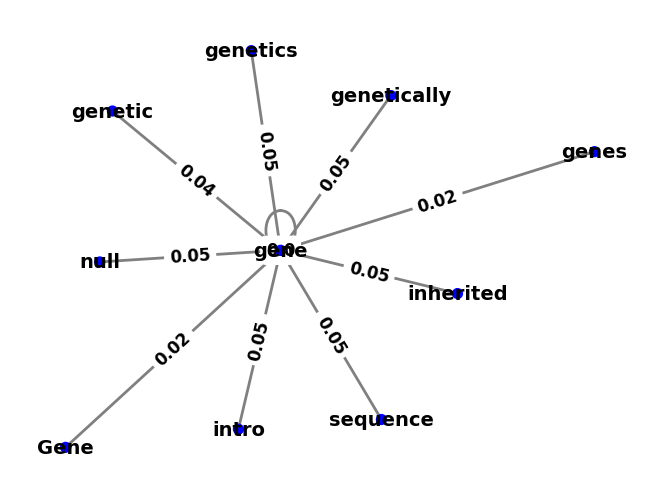

In [ ]:
import networkx as nx

# Create a networkx graph
G = nx.Graph()

# Add nodes for each word, with the input word as the central node
G.add_node(word1, label=word1, color='red', size=100)

# Add edges between the input word and its nearest neighbors, with edge weight equal to the cosine distance
for i in range(n_neighbors):
    neighbor_word = list(vocab_embeddings.keys())[indices[0][i]]
    neighbor_distance = distances[0][i]
    G.add_node(neighbor_word, label=neighbor_word, color='blue', size=50)
    G.add_edge(word1, neighbor_word, weight=neighbor_distance)

# Visualize the graph
pos = nx.spring_layout(G, seed=42) # Layout the nodes using the spring layout algorithm
nx.draw(G, pos, with_labels=True, node_size=[G.nodes[node]['size'] for node in G], node_color=[G.nodes[node]['color'] for node in G], edge_color='gray', width=2, font_size=14, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(word1, neighbor_word): round(weight, 2) for (word1, neighbor_word, weight) in G.edges(data='weight')}, font_size=12, font_weight='bold')
plt.show()


# **Just the distances to nearest neighbors of the input word (gene) with the nearest being on the left hand side**

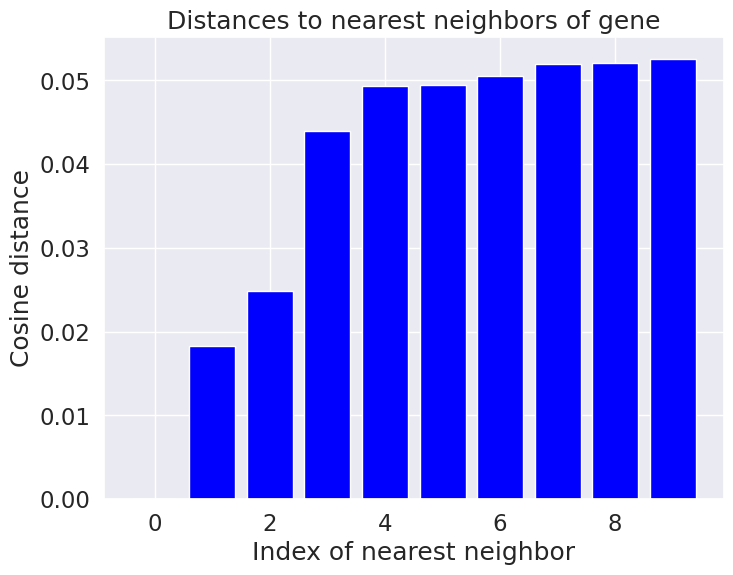

In [ ]:
# Plot the distances of each word to the input word
distances = distances[0]
plt.figure(figsize=(8, 6))
plt.bar(range(len(indices[0])), distances, color='blue')
plt.xlabel('Index of nearest neighbor')
plt.ylabel('Cosine distance')
plt.title('Distances to nearest neighbors of %s' % word1)
plt.show()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Set up BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# Get the full BioBERT vocabulary
vocab = tokenizer.get_vocab()

# Input words
word1 = "gene"

# Get embeddings for word1
inputs1 = tokenizer(word1, return_tensors='pt')
outputs1 = model(**inputs1)
embedding1 = outputs1.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

# Find the embeddings and words for all words in the vocabulary
words = list(vocab.keys())
# [:50]


vocab_embeddings = {}
for word in words:
    if len(word) >= 2:
        inputs = tokenizer(word, return_tensors='pt')
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        vocab_embeddings[word] = embedding

# Use KNN to find the most similar words to the input word
n_neighbors = 10
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn.fit(list(vocab_embeddings.values()))
distances, indices = nn.kneighbors([embedding1])

# Plot the word vectors for the input word and its nearest neighbors
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding1[0], embedding1[1], c='red', label=word1)
for i in range(n_neighbors):
    neighbor_word = list(vocab_embeddings.keys())[indices[0][i]]
    neighbor_embedding = vocab_embeddings[neighbor_word]
    ax.scatter(neighbor_embedding[0], neighbor_embedding[1], label=neighbor_word)
ax.legend()
plt.show()


ModuleNotFoundError: ignored

In [ ]:
vocab = tokenizer.get_vocab()
print(len(vocab))

28996


In [ ]:

if len(vocab) == len(set(vocab)):
    print("There are no duplicates in the list.")
else:
    print("There are duplicates in the list.")

There are no duplicates in the list.
